In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage import io
from PIL import Image, ImageEnhance
from skimage.exposure import match_histograms

%matplotlib inline

# 预处理工作

## 读取图像

In [2]:
idx = 0
I = io.imread(f'RefImg/RefImg_{idx}.bmp').astype('uint8')
J = io.imread(f'RealImg/RealImg_{idx}.bmp').astype('uint8')
original_I = I.copy()
original_J = J.copy()

h1, w1 = I.shape
h2, w2 = J.shape

## 可视化图像和直方图
这里可以看出，两张图片的直方图分布差异很大

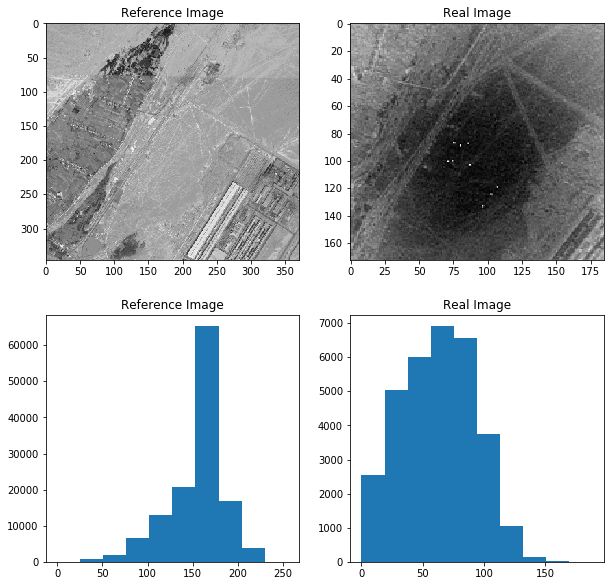

In [3]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(2,2,1)
plt.imshow(I, cmap='gray')
plt.title("Reference Image")
fig.add_subplot(2,2,2)
plt.imshow(J, cmap='gray') 
plt.title("Real Image")
fig.add_subplot(2,2,3)
plt.hist(I.ravel())
plt.title("Reference Image")
fig.add_subplot(2,2,4)
plt.hist(J.ravel())
plt.title("Real Image")
plt.show()

## 直方图匹配
将图像`J`的直方图匹配至图像`I`，发现直方图匹配后整张图片都平滑了，边缘特征不够明显

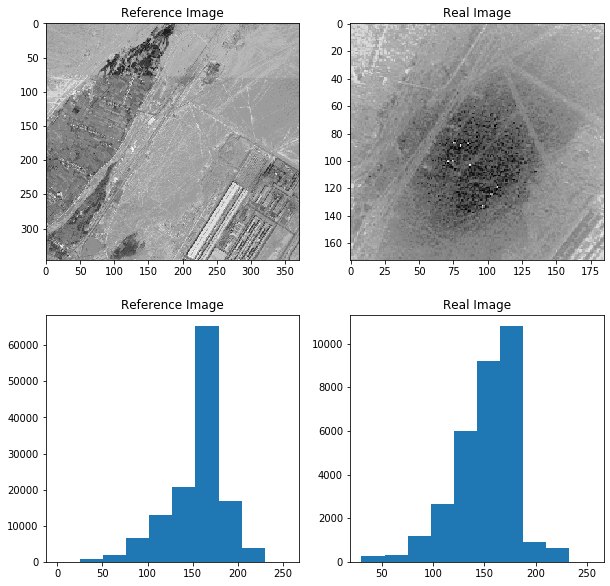

In [4]:
# 直方图匹配函数
J = match_histograms(original_J, I, multichannel=False).astype('uint8')

fig=plt.figure(figsize=(10, 10))
fig.add_subplot(2,2,1)
plt.imshow(I, cmap='gray')
plt.title("Reference Image")
fig.add_subplot(2,2,2)
plt.imshow(J, cmap='gray') 
plt.title("Real Image")
fig.add_subplot(2,2,3)
plt.hist(I.ravel())
plt.title("Reference Image")
fig.add_subplot(2,2,4)
plt.hist(J.ravel())
plt.title("Real Image")
plt.show()

## 图像增强（亮度增强）
发现实时图像亮度较暗，使用图像增强技术放大像素点，在保持图像亮度的同时保留边缘特征


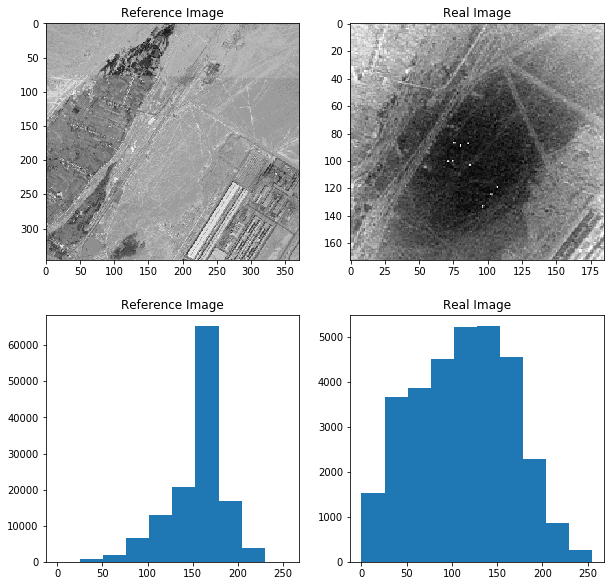

In [5]:
# 图像亮度增强1.8倍
J = ImageEnhance.Brightness(Image.fromarray(original_J)).enhance(1.8)
J = np.asarray(J)

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(2,2,1)
plt.imshow(I, cmap='gray')
plt.title("Reference Image")
fig.add_subplot(2,2,2)
plt.imshow(J, cmap='gray') 
plt.title("Real Image")
fig.add_subplot(2,2,3)
plt.hist(I.ravel())
plt.title("Reference Image")
fig.add_subplot(2,2,4)
plt.hist(J.ravel())
plt.title("Real Image")
plt.show()

# 图像配准辅助函数
下列函数是用于图像配准的可视化工具函数

In [6]:
def ImageRegistration(I, J, dx, dy):
    """
    图像配准，给定偏移量，将两张图像合成
    
    Arguments:
    -----------
    I: 输入的基准图像
    J：实时图像（待配准）
    dx：实时图像在基准图像 （高度）Y 轴上的偏移
    dy：实时图像在基准图像 （宽度）X 轴上的偏移
    
    Returns:
    -----------
    配准后的图像
    
    """
    h1, w1 = I.shape
    h2, w2 = J.shape
    img = I.copy()
    img[dx: min(dx+h2, h1), dy:min(dy+w2, w1)] = J[:min(h2, h1-dx), :min(w2, w1-dy)]
    return img

def plot(I, J, dx, dy):
    """
    显示四张图像
    1. 参考图像
    2. 实时图像
    3. 参考图像中与实时图像配准部分的图像
    4. 配准后的图像
    
    Arguments:
    -----------
    I: 输入的基准图像
    J：实时图像（待配准）
    dx：实时图像在基准图像 （高度）Y 轴上的偏移
    dy：实时图像在基准图像 （宽度）X 轴上的偏移
    
    
    """    
    h1, w1 = I.shape
    h2, w2 = J.shape
    img = ImageRegistration(I, J, dx, dy)
    fig = plt.figure(figsize=(30,30))
    fig.add_subplot(1,4,1)
    plt.imshow(I, cmap='gray')
    plt.title("Reference Image", fontsize=30)
    fig.add_subplot(1,4,2)
    plt.imshow(J, cmap='gray') 
    plt.title("Real Image", fontsize=30)
    fig.add_subplot(1,4,3)
    plt.imshow(I[dx:dx+h2, dy:dy+w2], cmap='gray')
    plt.title("Selected Part of Reference Image", fontsize=30)
    fig.add_subplot(1,4,4)
    plt.imshow(img, cmap='gray') 
    plt.title("Registered Image", fontsize=30)
    plt.tight_layout()

# 基于像素点的配准

## 根据互信息熵 (MI) 进行配准
信息熵
$$
H(x)= - \sum_{x=1}^{N}\mbox p(x)log p(x)
$$
其中，$x$为像素值，$N$为像素值的数目（一般为255）

联合熵
$$
H(x, y)= - \sum_{x,y} \mbox p(x,y)log p(x,y)
$$

互信息熵
$$
MI(x,y) = H(x) + H(y) - H(x,y)
$$

In [7]:
EPS = np.finfo(float).eps

def mutual_information_2d(x, y, sigma=1, normalized=False):
    # 联合分布概率
    jh = np.histogram2d(x, y, bins=(256, 256))[0]

    jh = jh + EPS
    sh = np.sum(jh)
    jh = jh / sh
    s1 = np.sum(jh, axis=0).reshape((-1, 256))
    s2 = np.sum(jh, axis=1).reshape((256, -1))

    # NOTE: 因为前面计算信息熵的时候没有取负，因此下面的计算公式与原公式相反
    if normalized:
        # NMI(x,y) = (H(x)HE(y))/H(x,y)
        mi = ((np.sum(s1 * np.log(s1)) + np.sum(s2 * np.log(s2))) / np.sum(jh * np.log(jh))) - 1
    else:
        # MI(x,y) = H(x)+H(y)-H(x,y)
        mi = np.sum(jh * np.log(jh)) - np.sum(s1 * np.log(s1)) - np.sum(s2 * np.log(s2))

    return mi


### 计算互信息熵
为参考图像 `I` 中的每一部分与实时图像 `J` 进行互信息熵计算

In [8]:
max_mi = 0.
for i in range(h1-h2):
    for j in range(w1-w2):
        K = I[i:i+h2, j:j+w2]
        mi = mutual_information_2d(J.ravel(), K.ravel())
        if mi > max_mi:
            dx = i
            dy = j
            max_mi = mi

### 可视化配准结果

可以看到结果很差，这是因为两张图片在像素点上的差异就非常之大

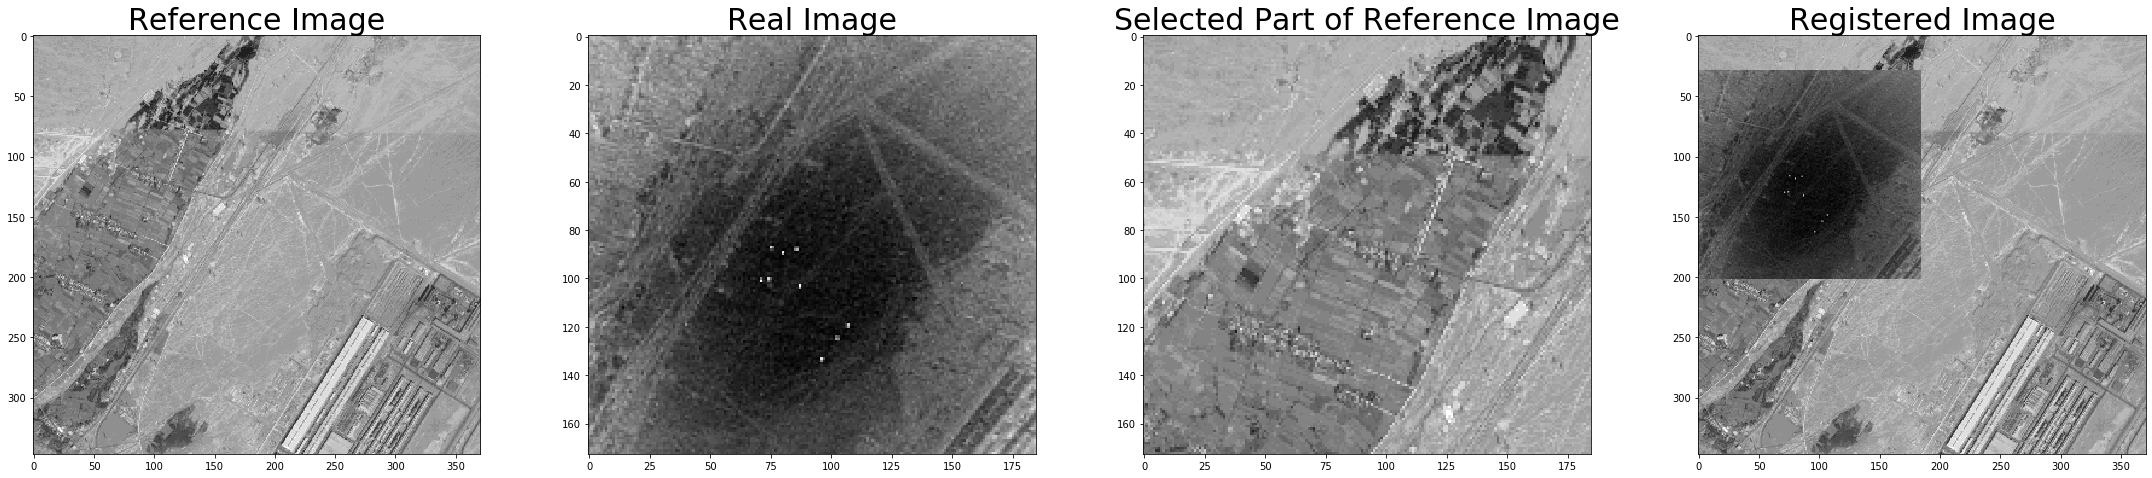

In [9]:
plot(I, original_J, dx, dy)

## 根据欧氏距离进行配准 

### 计算欧氏距离
为参考图像 `I` 中的每一部分与实时图像 `J` 进行互信息熵计算
欧氏距离
$$
D = \sqrt{(x^2+y^2)}
$$

In [10]:
max_D = 0.
for i in range(h1-h2):
    for j in range(w1-w2):
        K = I[i:i+h2, j:j+w2]
        D = np.square(J - K).sum()
        if D > max_D:
            dx = i
            dy = j
            max_D = D

### 可视化配准结果
类似的，效果也不好

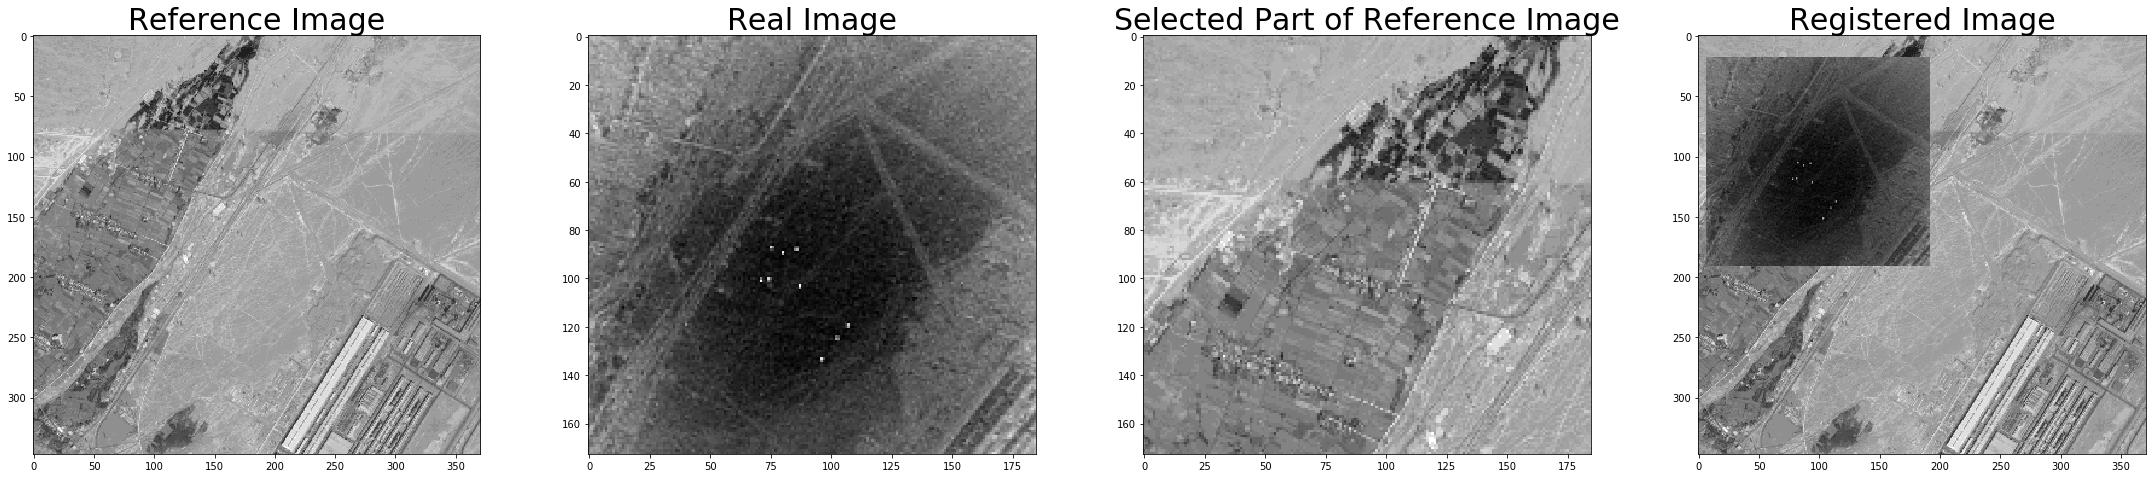

In [11]:
plot(I, original_J, dx, dy)

# 基于点特征的配准

## SIFT 算法 

尺度不变特征转换(Scale-invariant feature transform或SIFT)是一种计算机视觉的算法用来侦测与描述影像中的局部性特征，它在空间尺度中寻找极值点，并提取出其位置、尺度、旋转不变量。
其应用范围包含物体辨识、机器人地图感知与导航、影像缝合、3D模型建立、手势辨识、影像追踪和动作比对。

SIFT算法分解为如下四步：
+ 尺度空间极值检测：搜索所有尺度上的图像位置。通过高斯微分函数来识别潜在的对于尺度和旋转不变的兴趣点。
+ 关键点定位：在每个候选的位置上，通过一个拟合精细的模型来确定位置和尺度。关键点的选择依据于它们的稳定程度。
+ 方向确定：基于图像局部的梯度方向，分配给每个关键点位置一个或多个方向。所有后面的对图像数据的操作都相对于关键点的方向、尺度和位置进行变换，从而提供对于这些变换的不变性。
+ 关键点描述：在每个关键点周围的邻域内，在选定的尺度上测量图像局部的梯度。这些梯度被变换成一种表示，这种表示允许比较大的局部形状的变形和光照变化。


In [12]:
# SIFT 算法
sift = cv2.xfeatures2d.SIFT_create()
# sift = cv2.xfeatures2d.SURF_create()
# sift = cv2.ORB_create()

# 算法分成了两步，第一步特征提取，第二步计算描述符
keypoints_I, descriptors_I= sift.detectAndCompute(I, None)
keypoints_J, descriptors_J = sift.detectAndCompute(J, None)

### 关键点可视化

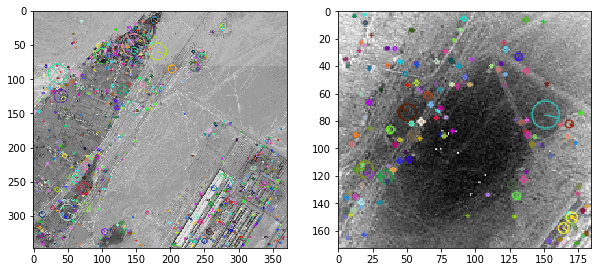

In [13]:
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
img = cv2.drawKeypoints(I, keypoints_I, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)#绘制关键点
plt.imshow(img, 'gray')
fig.add_subplot(1,2,2)
img = cv2.drawKeypoints(J, keypoints_J, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)#绘制关键点
plt.imshow(img, 'gray')

### 暴力搜索和最近邻匹配（K=2）
对于`J`中的每个特征点匹配得到`I`中最近的两个邻居后，根据以下原则选取较优匹配：
+ 该点与最近邻居的距离小于该点与第二近邻居距离的$\alpha$倍


In [14]:
# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# search_params = dict(checks = 50)
# matches = cv2.FlannBasedMatcher(index_params, search_params).knnMatch(descriptors_I, descriptors_J, k=2)

bf = cv2.BFMatcher(crossCheck=False)
matches = bf.knnMatch(descriptors_I, descriptors_J, k=2)

good = []
for m, n in matches:
    if m.distance < 0.825*n.distance:
        good.append([m])

### 匹配点可视化

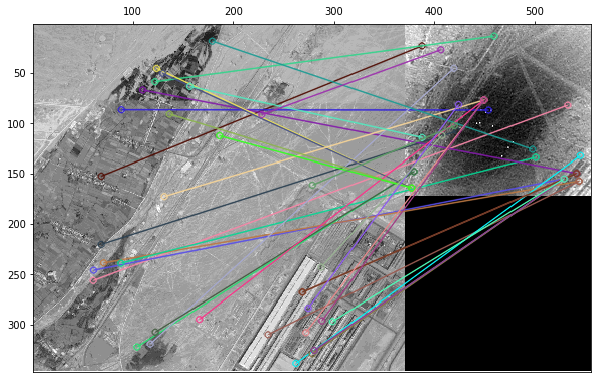

In [15]:
imMatches = cv2.drawMatchesKnn(I, keypoints_I, J, keypoints_J, good, None, flags=2)

plt.figure(figsize = (10, 10))
ax = plt.gca()
ax.xaxis.set_ticks_position('top')
ax.set_xlim(1, imMatches.shape[1])
ax.yaxis.set_ticks_position('left')  
ax.set_ylim(imMatches.shape[0],1) 
ax.imshow(imMatches)

### 计算偏移量

In [16]:
# 获取匹配良好的特征点坐标
points1 = np.zeros((len(good), 2), dtype=np.float32)
points2 = np.zeros((len(good), 2), dtype=np.float32)

for i, match in enumerate(good):
    points1[i, :] = keypoints_I[match[0].queryIdx].pt
    points2[i, :] = keypoints_J[match[0].trainIdx].pt
    
# 根据坐标相差的平均值计算偏移量
dx, dy = (points1-points2).mean(0).astype('uint8')
print('使用均值计算的偏移量', dy, dx)

# 根据坐标相差的平均值计算偏移量
# 在这之前先去掉最大值和最小值以避免偏差点
x, y = (points1-points2).T
x.sort(), y.sort()
k1, k2 = 1, 1
dxx, dyy = x[k1:-k1].mean().astype('int'),  y[k2:-k2].mean().astype('int')
print('使用去偏均值计算的偏移量', dyy, dxx)

使用均值计算的偏移量 94 89
使用去偏均值计算的偏移量 95 89


### 图像配准可视化

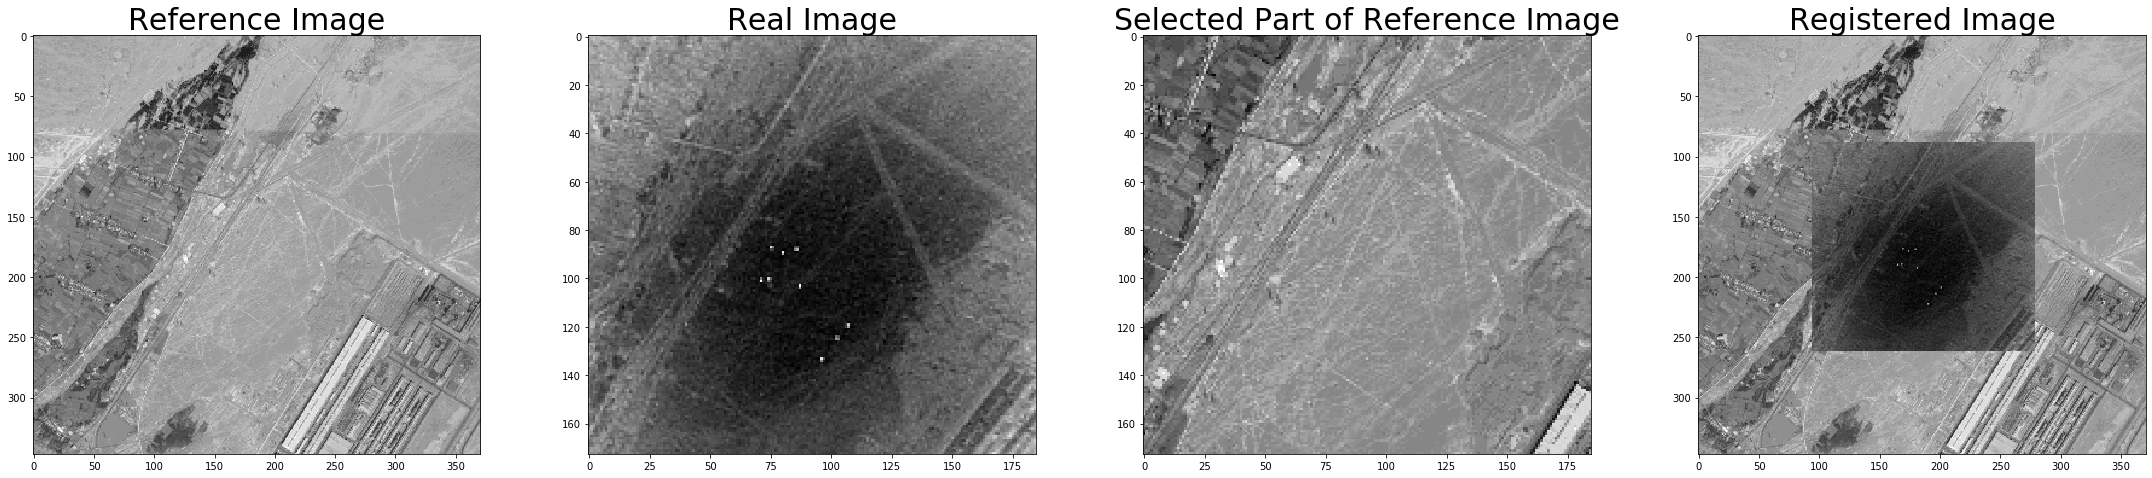

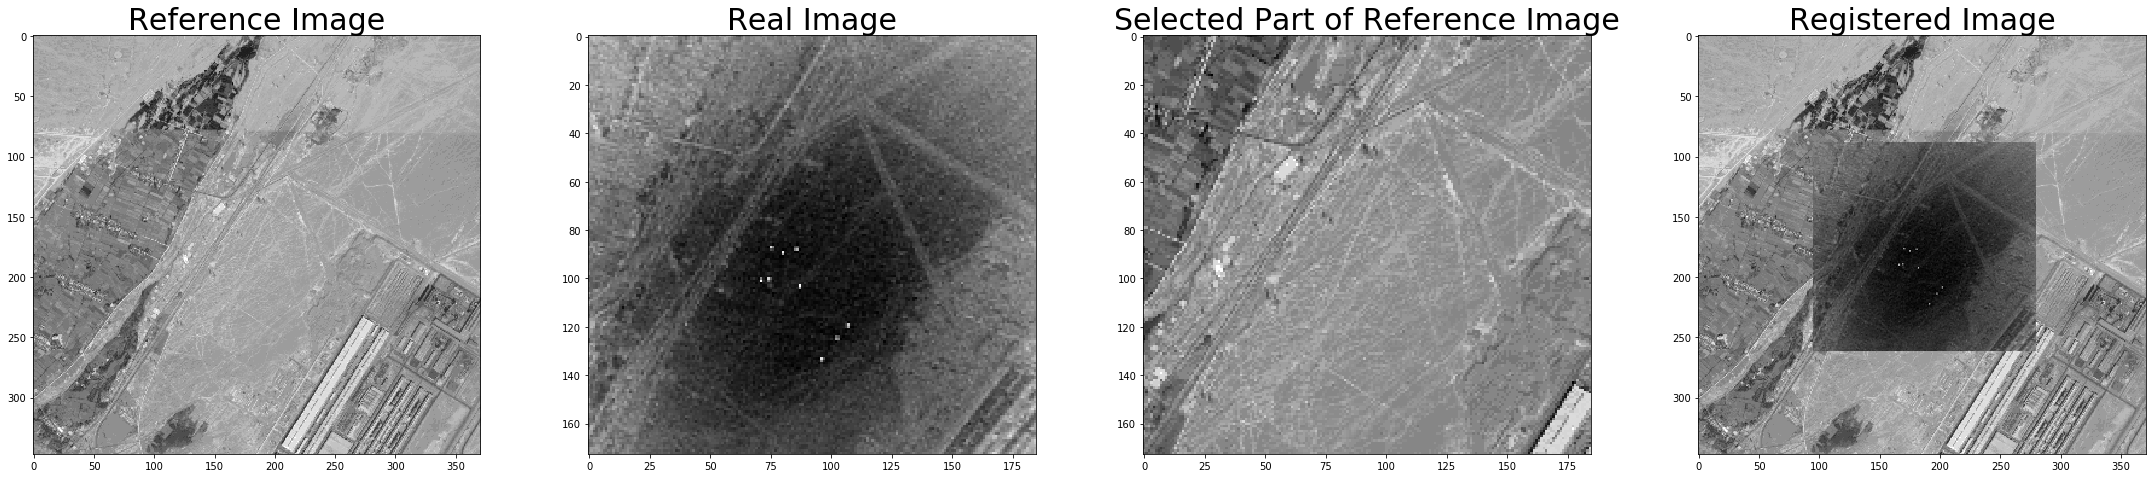

In [17]:
# 使用均值计算的偏移量
plot(I, original_J, dx, dy)
# 使用去偏均值计算的偏移量
plot(I, original_J, dxx, dyy)